# Homework 3

Before starting notebook, activate viz: *jupyter nbextension enable vega --py*

In [27]:
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
import json
import os
import csv
%matplotlib inline

## Initial variables and helper functions

In [28]:
topo_path_json_eu = os.path.join('topojson', 'europe.topojson.json')
topo_path_json_ch = os.path.join('topojson', 'ch-cantons.topojson.json')

path_unemployment_eu_month = os.path.join('FetchedData', 'Unemployment_rate_EU.tsv')

color_undef = "#bdbdbd"

# picked with colorbrewer, orange since unemployment rate is bad
color_classes = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']

## Our definition of unemployment rate

We define unemployment rate as the quaterly seasonal adjusted rate of people who declared their unemployment, while having no job.
We do not differentiate between male and female or ages.

## Unemployment rate in Europe at a country level

The chosen dataset from the EU contains information for people of the ages 15 - 74.  
We picked the dataset which differentiates between education, because it contains Switzerland. The basic datasets did not contain Switzerland.  
In order to calculate the total unemployment rate we took the mean of the unemployment rate of the educational classes.

In [29]:
map_europe = folium.Map([57,18], zoom_start=3)

### Preprocess downloaded data

In [30]:
df_unemployment_eu_month = pd.read_csv(path_unemployment_eu_month, sep='\t')
df_unemployment_eu_month.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,2017Q1,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,...,2000Q2,2000Q1,1999Q4,1999Q3,1999Q2,1999Q1,1998Q4,1998Q3,1998Q2,1998Q1
0,"F,ED0-2,Y15-74,NSA,PC_ACT,AT",11.2,12.3,11.4,11.3,10.6,10.3,9.8,9.3,9.6,...,5.7,7.3,5.5,5.0,4.7,6.7,:,:,:,8.6
1,"F,ED0-2,Y15-74,NSA,PC_ACT,BE",14.3,17.5 b,13.0,17.4,16.7,17.3,16.4,14.7,15.8,...,14.1,15.8,16.3,16.9,17.3,18.8 b,:,:,19.3,:
2,"F,ED0-2,Y15-74,NSA,PC_ACT,BG",19.1,26.0,22.1,20.9,24.2,26.8,24.8,24.5,26.0,...,27.2,34.9,:,:,:,:,:,:,:,:
3,"F,ED0-2,Y15-74,NSA,PC_ACT,CH",8.5,9.4,9.2,9.1,9.4,9.3,7.5,11.3,9.0,...,:,:,:,:,:,:,:,:,:,:
4,"F,ED0-2,Y15-74,NSA,PC_ACT,CY",11.5,14.2,13.0,10.9,12.3,13.9,8.5,13.4,16.1,...,8.6,:,:,:,:,:,:,:,:,:


In [31]:
# Filter colums: Only use latest month
cols_drop = [i for i in range(2,len(df_unemployment_eu_month.columns))]
df_unemployment_eu_month_clean = df_unemployment_eu_month.drop(df_unemployment_eu_month.columns[cols_drop], axis=1)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2
0,"F,ED0-2,Y15-74,NSA,PC_ACT,AT",11.2
1,"F,ED0-2,Y15-74,NSA,PC_ACT,BE",14.3
2,"F,ED0-2,Y15-74,NSA,PC_ACT,BG",19.1
3,"F,ED0-2,Y15-74,NSA,PC_ACT,CH",8.5
4,"F,ED0-2,Y15-74,NSA,PC_ACT,CY",11.5


In [32]:
# Filter rows
"""
T := male and female
* := keep all educational classes
Y15-74 := maximum age range
SA := seasonal adjusted
PC_ACT = percentage of popolation
"""
unempl_filter = r"^T,(.*),Y15-74,SA,PC_ACT,(.*)"
df_unemployment_eu_month_clean = df_unemployment_eu_month_clean[df_unemployment_eu_month_clean.iloc[:,0].str.contains(unempl_filter)]
df_unemployment_eu_month_clean.head()

/Users/besmaelketroussi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.


,"sex,isced11,age,s_adj,unit,geo\time",2017Q2
4368,"T,ED0-2,Y15-74,SA,PC_ACT,AT",13.1
4369,"T,ED0-2,Y15-74,SA,PC_ACT,BE",15.2
4370,"T,ED0-2,Y15-74,SA,PC_ACT,BG",18.5
4371,"T,ED0-2,Y15-74,SA,PC_ACT,CH",8.4
4372,"T,ED0-2,Y15-74,SA,PC_ACT,CY",14.8


In [33]:
# Filter country id
df_unemployment_eu_month_clean["country"] = df_unemployment_eu_month_clean.iloc[:,0].replace({ unempl_filter : r'\2'}, regex=True)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,"T,ED0-2,Y15-74,SA,PC_ACT,AT",13.1,AT
4369,"T,ED0-2,Y15-74,SA,PC_ACT,BE",15.2,BE
4370,"T,ED0-2,Y15-74,SA,PC_ACT,BG",18.5,BG
4371,"T,ED0-2,Y15-74,SA,PC_ACT,CH",8.4,CH
4372,"T,ED0-2,Y15-74,SA,PC_ACT,CY",14.8,CY


In [34]:
# Reformat filter to only contain education category
df_unemployment_eu_month_clean.iloc[:,0] = df_unemployment_eu_month_clean.iloc[:,0].replace({ unempl_filter : r'\1'}, regex=True)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,ED0-2,13.1,AT
4369,ED0-2,15.2,BE
4370,ED0-2,18.5,BG
4371,ED0-2,8.4,CH
4372,ED0-2,14.8,CY


In [35]:
# Replace unkown values, denoted by ":", remove "u" warning for low accuracy
df_unemployment_eu_month_clean.iloc[:,1] = df_unemployment_eu_month_clean.iloc[:,1].apply(
    lambda x : x.replace("u", ""))
df_unemployment_eu_month_clean.iloc[:,1] = df_unemployment_eu_month_clean.iloc[:,1].apply(
    lambda x : np.NAN if ":" in x else x)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,ED0-2,13.1,AT
4369,ED0-2,15.2,BE
4370,ED0-2,18.5,BG
4371,ED0-2,8.4,CH
4372,ED0-2,14.8,CY


In [36]:
# convert unemployment to float
df_unemployment_eu_month_clean.iloc[:,1] = pd.to_numeric(df_unemployment_eu_month_clean.iloc[:,1], errors='coerce')
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,ED0-2,13.1,AT
4369,ED0-2,15.2,BE
4370,ED0-2,18.5,BG
4371,ED0-2,8.4,CH
4372,ED0-2,14.8,CY


In [37]:
pd.isnull(df_unemployment_eu_month_clean).any()

sex,isced11,age,s_adj,unit,geo\time    False
2017Q2                                  True
country                                False
dtype: bool

In [38]:
df_unemployment_eu_month_clean[pd.isnull(df_unemployment_eu_month_clean.iloc[:,1])]

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
5812,ED5-8,NaN,MT


Use default behavior of pandas and calculate mean with only two education categories

In [39]:
df_unemployment_eu_month_clean = df_unemployment_eu_month_clean.groupby("country").mean()
df_unemployment_eu_month_clean.head()

,2017Q2
country,
AT,7.033333
BE,8.900000
BG,8.900000
CH,5.533333
CY,11.900000


In [40]:
df_unemployment_eu_month_clean.iloc[:,0].sort_values().head(10)

country
IS    2.766667
RO    4.733333
MT    4.900000
DE    4.933333
UK    5.000000
NO    5.200000
CH    5.533333
NL    5.566667
LU    5.700000
HU    5.800000
Name: 2017Q2 , dtype: float64

### Create vizualisation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d2d9208>]], dtype=object)

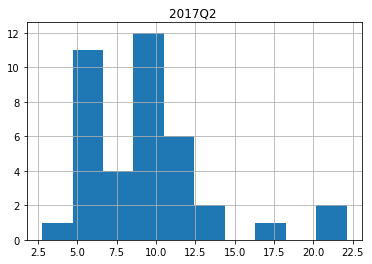

In [41]:
df_unemployment_eu_month_clean.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dc0fa20>]], dtype=object)

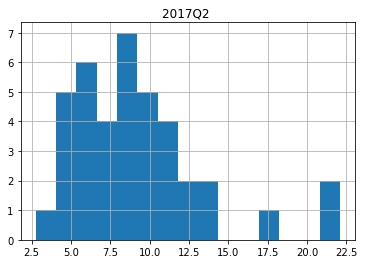

In [42]:
df_unemployment_eu_month_clean.hist(bins=15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10deeef60>]], dtype=object)

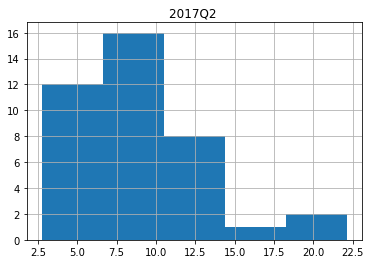

In [43]:
df_unemployment_eu_month_clean.hist(bins=5)

We decided to take 5 bins, since not to much information gets lost and more than seven colors can only hardly be distincted

In [44]:
def eu_map_country_id(country_id_geo_json):
    """Handles Mapping between country ids"""
    if country_id_geo_json == "FR":
        return "FX"
    elif country_id_geo_json == "GB":
        return "UK"
    elif country_id_geo_json == "GR":
        return "EL"
    else:
        return country_id_geo_json

In [45]:
def eu_get_umepmloyment_rate(country_id):
    """Fetches the unemployment rate for a given country from the data frame"""
    try:
        row = df_unemployment_eu_month_clean.loc[eu_map_country_id(country_id)].values
        return row[0]
    except KeyError:
        #print ("Country with id {} not found in dataset".format(country_id))
        return -1

In [46]:
# calculate bin for unemployment
count, division = np.histogram(df_unemployment_eu_month_clean.iloc[:,0], bins=5)
def eu_get_class(unempl_rate):
    """Calculates the class based on the real value"""
    if unempl_rate < division[1]:
        return 0
    elif unempl_rate < division[2]:
        return 1
    elif unempl_rate < division[3]:
        return 2
    elif unempl_rate < division[4]:
        return 3
    else:
        return 4

In [47]:
def eu_class_color(class_id):
    """Fetches the color code based on the class"""
    return color_classes[class_id]

In [48]:
def eu_unemployment_colors(country_id):
    """Returns the color based on the unemployment rate for the given country"""
    unempl_rate = eu_get_umepmloyment_rate(country_id)
    if unempl_rate == -1:
        return color_undef
    else:
        class_id = eu_get_class(unempl_rate)
        return eu_class_color(class_id)

In [49]:
with open(topo_path_json_eu) as f:
    
    j = json.load(f)
    
    # Create an own topojson object in order to display popups 
    topojson = [{'type': j['type'],
                 'objects': {'europe': {
                     'type': "GeometryCollection",
                     'geometries': [f]}},
                 'arcs' : j['arcs'],
                 'transform' : j['transform']} 
                for f in j['objects']['europe']['geometries']]
    
    # Add each topojson
    for tj in map(lambda tj: folium.TopoJson(tj,
                                             "objects.europe", style_function=lambda country: {
                                                'fillColor': eu_unemployment_colors(country['id']),
                                                'fillOpacity': 1,
                                                'weight': 1,
                                                'color' : 'black',
                                                'dashArray' : '0, 0'}),
                  topojson):
        
        # fetch details for popup
        unemployment_rate = eu_get_umepmloyment_rate(tj.data['objects']['europe']['geometries'][0]['id'])
        country = tj.data['objects']['europe']['geometries'][0]['properties']['NAME']
    
        # beautify popup
        if unemployment_rate == -1:
            html = """
                <h3> """+country+""" </h3> </br>
                <p> Unemployment rate: unavailable </p> """
        else :
            html = """
                <h3> """+country+""" </h3> </br>
                <p> Unemployment rate: """+"{0:.2f}%".format(unemployment_rate)+""" </p> """
            
        # add popup and topojson
        tj.add_child(folium.Popup(html))
        tj.add_to(map_europe)

In [50]:
# Add legend
min_ = min(df_unemployment_eu_month_clean.values)[0]
max_= max(df_unemployment_eu_month_clean.values)[0]

colormap = cm.StepColormap(
            color_classes,
            index=division,
            vmin=min_,
            vmax=max_,
            caption="Unemployment rate [%]",
            )
map_europe = map_europe.add_child(colormap)

In [51]:
# Moves slowly due to many topojsons, but has popups :)
map_europe.save('EU_unemployment_rate.html')

Access the map [here](EU_unemployment_rate.html). Click on the countries in order to display the exact unemployment rate of the country.

### Comparison Switzerland to the rest of Europe

Switzerland's unemployment rate puts Switzerland in the first class, which has the lowest unemployment rate in Europe.  
This means that Switzerland's unemployment rate is between 3% and 7%
Exactly Switzerland is the country with the 7th lowest unemployment rate of 5.53% .

## Unemployment rate in Switzerland at a canton level

15+

In [52]:
#state_geo = os.path.join('data', 'us-states.json')

#state_unemployment = os.path.join('data', 'US_Unemployment_Oct2012.csv')
#state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

m.choropleth(
    geo_data="",
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
)

m

NameError: name 'state_data' is not defined

In [131]:
#read data
path = os.path.join('FetchedData', 'Unemployment_rate_swiss_and_foreigners.xlsx')
df_unemployment_swiss_foreigners = pd.read_excel(path)

#set index to Canton and Nationality
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners.set_index(['Canton','Nationalité']).drop(['Mois'], axis = 1)

#Keep the second quaterly to match our definition
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.iloc[:,6:12]

#Keep the percentage only
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.drop(['Avril 2017.1','Mai 2017.1','Juin 2017.1'],axis=1) 
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.iloc[1:]

In [132]:
df_unemployment_swiss_foreigners_clean

Avril 2017 Mai 2017 Juin 2017
Canton                       Nationalité                              
Zurich                       Etrangers            6      5.7       5.6
                             Suisses            2.7      2.6       2.6
Berne                        Etrangers          6.8      6.2       5.7
                             Suisses              2      1.9       1.8
Lucerne                      Etrangers          4.6      4.3       4.1
                             Suisses            1.3      1.3       1.2
Uri                          Etrangers          5.3      4.1         3
                             Suisses            0.6      0.6       0.5
Schwyz                       Etrangers            4      3.6       3.5
                             Suisses            1.2      1.2       1.1
Obwald                       Etrangers            3      2.4       2.4
                             Suisses            0.6      0.5       0.5
Nidwald                      Etrangers          3.6      3.5       3.2
                             Suisses            0.7      0.7       0.7
Glaris                       Etrangers          4.6      4.3       3.9
                             Suisses            1.6      1.5       1.4
Zoug                         Etrangers          4.3      4.2         4
                             Suisses            1.8      1.8       1.7
Fribourg                     Etrangers          5.3      4.7       4.4
                             Suisses            1.9      1.7       1.8
Soleure                      Etrangers            6      5.8       5.4
                             Suisses            2.1        2       1.9
Bâle-Ville                   Etrangers          5.3        5         5
                             Suisses              3      2.8       2.7
Bâle-Campagne                Etrangers          5.3      5.1         5
                             Suisses            2.2      2.2       2.2
Schaffhouse                  Etrangers          5.9      5.9       5.5
                             Suisses            2.3      2.4       2.3
Appenzell Rhodes-Extérieures Etrangers          3.9      3.7       3.6
                             Suisses            1.3      1.3       1.3
Appenzell Rhodes-Intérieures Etrangers          2.8      2.5       2.5
                             Suisses            0.7      0.5       0.6
St-Gall                      Etrangers          4.9      4.6       4.4
                             Suisses            1.6      1.5       1.5
Grisons                      Etrangers          6.1      5.2       2.6
                             Suisses              1      0.9       0.8
Argovie                      Etrangers          6.4      6.1       5.9
                             Suisses            2.2      2.1       2.1
Thurgovie                    Etrangers          4.5      4.2         4
                             Suisses            1.5      1.5       1.4
Tessin                       Etrangers            5      4.7       4.5
                             Suisses            2.6      2.5       2.4
Vaud                         Etrangers          6.6      6.3       5.8
                             Suisses            3.5      3.4       3.4
Valais                       Etrangers          7.7      6.3       5.2
                             Suisses            2.3      2.3       2.1
Neuchâtel                    Etrangers            9      8.4       7.6
                             Suisses            4.6      4.4       4.2
Genève                       Etrangers            6      5.9       5.8
                             Suisses            4.7      4.6       4.6
Jura                         Etrangers           10      9.5       9.4
                             Suisses            3.7      3.5       3.4
Total                        NaN                3.3      3.1         3